# Imports

In [1]:
using CSV
using DataFrames
using Statistics
using Dates
using Random
using Plots
using StatsBase
using GLM
using StatsPlots

# Cleaning the data

## Eliminating double comas ",," after wrong column
Changing them to ","

In [2]:
# Preparar paths
path = "dataSets/damCombustible.csv"
cleaned_path = "dataSets/damCombustible_cleaned.csv"

# Corregir cada linea del CSV
function fix_csv_line(line::String)
    parts = split(line, ",")
    horometro_index = 3
    
    if length(parts) > horometro_index + 1 && !isempty(parts[horometro_index + 1])
        while length(parts) > horometro_index + 2 && parts[horometro_index + 2] == ""
            parts = vcat(parts[1:horometro_index + 1], parts[horometro_index + 3:end])
        end
    end

    return join(parts, ",")
end
        

function correct_csv_file(input_path::String, output_path::String)
    csv_lines = readlines(input_path)

    fixed_lines = [fix_csv_line(line) for line in csv_lines]

    open(output_path, "w") do file
        for line in fixed_lines
            println(file, line)
        end
    end
end

correct_csv_file(path, cleaned_path)

df = CSV.read(cleaned_path, DataFrame)
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,Nro.,320.709,2,322.5,638,0,Int64
2,Vehículo,105.566,101,105.0,110,0,Int64
3,Odómetro,8.12749e5,436624,1.0034e6,1142707,0,Int64
4,Horómetro,40.0,4,33.0,86,618,"Union{Missing, Int64}"
5,Fecha,,01/abr./2024 12:39:00,,31/may./2024 1:54:00,0,String31
6,Tanqueo Full,,N,,S,0,String1
7,Costo por Volumen,,"23,24",,"26,97",0,String7
8,Cant.,,100,,"99,13",0,String7
9,Unidad,,Litros,,Litros,0,String7


## Changing columns data-type to correct data-type
Fecha = DateTime

Tanqueo Full = Int 0 - 1

Costo por Volumen = Float32

Cantidad = Float32

Costo Total = Float32

In [3]:
propertynames(df)

12-element Vector{Symbol}:
 Symbol("Nro.")
 :Vehículo
 :Odómetro
 :Horómetro
 :Fecha
 Symbol("Tanqueo Full")
 Symbol("Costo por Volumen")
 Symbol("Cant.")
 :Unidad
 Symbol("Costo Total")
 :Tipo
 :Column12

In [4]:
# Rename columns
rename!(df, Symbol("Nro.") => :Numero,
    :Vehículo => :Vehiculo, :Odómetro => :Odometro,
    :Horómetro => :Horometro,
    Symbol("Tanqueo Full") => :Tanque_Lleno,
    Symbol("Costo por Volumen") => :Costo_Por_Volumen,
    Symbol("Cant.") => :Cantidad,
    Symbol("Costo Total") => :Costo_Total)

# Drop useless Columns
select!(df, Not(:Column12, :Horometro, :Unidad, :Tipo))

propertynames(df)

8-element Vector{Symbol}:
 :Numero
 :Vehiculo
 :Odometro
 :Fecha
 :Tanque_Lleno
 :Costo_Por_Volumen
 :Cantidad
 :Costo_Total

In [5]:
df

Row,Numero,Vehiculo,Odometro,Fecha,Tanque_Lleno,Costo_Por_Volumen,Cantidad,Costo_Total
,Int64,Int64,Int64,String31,String1,String7,String7,String7
1,634,101,1086986,06/ago./2024 17:33:18,S,"24,95",20,499
2,633,101,1086986,06/ago./2024 17:29:56,S,"25,38",394,9999
3,637,102,1023146,06/ago./2024 6:23:00,S,"24,57",127,3120
4,638,110,595357,06/ago./2024 3:51:00,S,"25,51",196,5000
5,636,105,492843,05/ago./2024 23:00:00,S,"24,57",127,3120
6,635,107,1106110,05/ago./2024 16:06:00,S,"24,79",115,2851
7,609,102,1022660,04/ago./2024 5:33:00,S,"25,8",141,3638
8,622,107,1105674,04/ago./2024 1:13:00,S,"25,86",124,3207
9,621,107,1105284,03/ago./2024 18:20:53,S,"25,69",111,2852


In [6]:
# Convert S and N to 1 and 0 respectively
# df.Tanque_Lleno = df.Tanque_Lleno .== "S"
transform!(df, :Tanque_Lleno => ByRow(x -> x == "S" ? 1 : 0) => :Tanque_Lleno)

#---------------------------------------------------------------

# Date convertion 
# Change spanish name to english
function replaceMonths(date)
    months = Dict(
        "ene." => "01", "feb." => "02", "mar." => "03", "abr." => "04",
        "may." => "05", "jun." => "06", "jul." => "07", "ago." => "08",
        "sep." => "09", "oct." => "10", "nov." => "11", "dic." => "12"
    )

    for (mes, month) in months
        if occursin(mes, date)
            return replace(date, mes => month)
        end
    end

    return date
end

df.Fecha = replaceMonths.(df.Fecha)

df.Fecha = Dates.DateTime.(df.Fecha, "dd/mm/yyyy HH:MM:SS")

#---------------------------------------------------------------

# Columns to convert with commas
columns_with_commas_to_convert = [:Costo_Por_Volumen, :Cantidad, :Costo_Total]

# Replace columns with dots and to float
for col in columns_with_commas_to_convert
    df[!, col] = replace.(df[!, col], "," => ".")
    df[!, col] = parse.(Float32, df[!, col])
end

In [7]:
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Any,Any,Int64,DataType
1,Numero,320.709,2,322.5,638,0,Int64
2,Vehiculo,105.566,101,105.0,110,0,Int64
3,Odometro,8.12749e5,436624,1.0034e6,1142707,0,Int64
4,Fecha,,2024-04-01T12:39:00,2024-05-31T16:37:16,2024-08-06T17:33:18,0,DateTime
5,Tanque_Lleno,0.800633,0,1.0,1,0,Int64
6,Costo_Por_Volumen,25.2959,23.24,25.29,26.97,0,Float32
7,Cantidad,160.645,13.0,120.025,665.0,0,Float32
8,Costo_Total,4058.61,329.0,3055.5,16353.0,0,Float32


In [8]:
size(df)

(632, 8)

# Suffle Data

In [9]:
# Firts we drop Fecha and Numero columns
df = select(df, Not(:Numero, :Fecha))

Row,Vehiculo,Odometro,Tanque_Lleno,Costo_Por_Volumen,Cantidad,Costo_Total
,Int64,Int64,Int64,Float32,Float32,Float32
1,101,1086986,1,24.95,20.0,499.0
2,101,1086986,1,25.38,394.0,9999.0
3,102,1023146,1,24.57,127.0,3120.0
4,110,595357,1,25.51,196.0,5000.0
5,105,492843,1,24.57,127.0,3120.0
6,107,1106110,1,24.79,115.0,2851.0
7,102,1022660,1,25.8,141.0,3638.0
8,107,1105674,1,25.86,124.0,3207.0
9,107,1105284,1,25.69,111.0,2852.0


In [10]:
# Mezclar los índices aleatoriamente
shuffled_df = df[shuffle(1:nrow(df)), :]

Row,Vehiculo,Odometro,Tanque_Lleno,Costo_Por_Volumen,Cantidad,Costo_Total
,Int64,Int64,Int64,Float32,Float32,Float32
1,104,1029078,0,24.59,160.0,3934.0
2,105,485729,1,25.63,120.0,3076.0
3,110,576038,1,24.95,301.0,7511.0
4,104,1012470,1,25.62,160.0,4099.0
5,105,487078,1,26.39,130.0,3431.0
6,104,1010282,1,25.49,90.23,2300.0
7,103,759105,1,24.59,130.37,3205.89
8,108,1134884,1,26.04,139.0,3619.0
9,106,452205,0,25.58,86.0,2200.0


# Scaling

In [11]:
# Function to normalize data
function normalize(column)
    min_val = minimum(column)
    max_val = maximum(column)
    return (column .- min_val) ./ (max_val .- min_val)
end

# Function to standardize data (Non-used, no normal distribution. No mean = 0 and std = 1)
function standardize(column)
    mean_val = mean(column)
    std_val = std(column)
    return (column .- mean_val) ./ std_val
end

# Funciton to normalize VECTORS
function normalize_vector(vector)
    min_val = minimum(vector)
    max_val = maximum(vector)
    return (vector .- min_val) ./ (max_val .- min_val)
end

transform!(shuffled_df, :Odometro => normalize => :Odometro_Norm,
    :Costo_Por_Volumen => normalize => :Costo_Por_Volumen_Norm, 
    :Cantidad => normalize => :Cantidad_Norm,
    :Costo_Total => normalize => :Costo_Total_Norm)

Row,Vehiculo,Odometro,Tanque_Lleno,Costo_Por_Volumen,Cantidad,Costo_Total,Odometro_Norm,Costo_Por_Volumen_Norm,Cantidad_Norm,Costo_Total_Norm
,Int64,Int64,Int64,Float32,Float32,Float32,Float64,Float32,Float32,Float32
1,104,1029078,0,24.59,160.0,3934.0,0.839071,0.36193,0.22546,0.224975
2,105,485729,1,25.63,120.0,3076.0,0.0695456,0.640751,0.16411,0.17143
3,110,576038,1,24.95,301.0,7511.0,0.197447,0.458445,0.441718,0.448203
4,104,1012470,1,25.62,160.0,4099.0,0.81555,0.63807,0.22546,0.235272
5,105,487078,1,26.39,130.0,3431.0,0.0714562,0.844504,0.179448,0.193585
6,104,1010282,1,25.49,90.23,2300.0,0.812451,0.603217,0.118451,0.123003
7,103,759105,1,24.59,130.37,3205.89,0.456718,0.36193,0.180015,0.179536
8,108,1134884,1,26.04,139.0,3619.0,0.988921,0.750671,0.193252,0.205317
9,106,452205,0,25.58,86.0,2200.0,0.0220668,0.627346,0.111963,0.116762


# Ploting

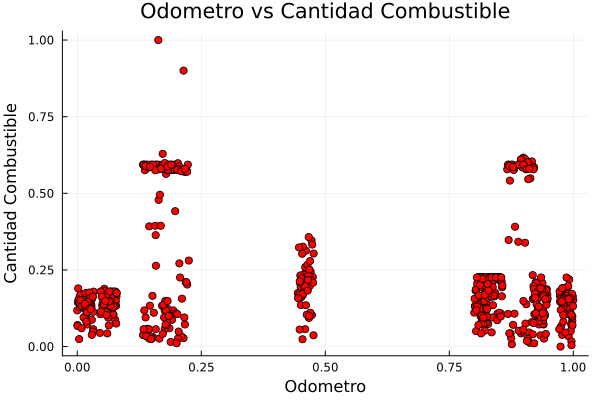

In [12]:
scatter(shuffled_df.Odometro_Norm, shuffled_df.Cantidad_Norm, title="Odometro vs Cantidad Combustible", xlabel="Odometro", ylabel="Cantidad Combustible", legend=false, color="red")

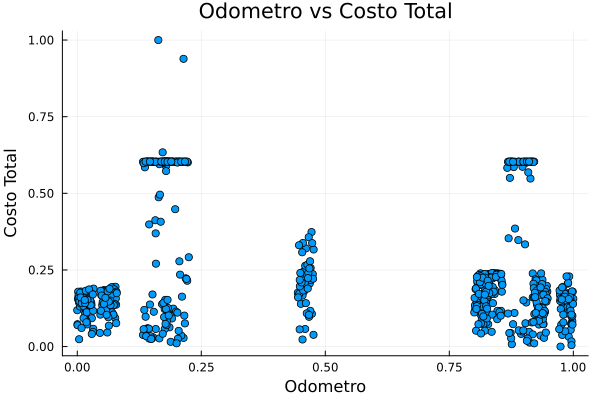

In [13]:
scatter(shuffled_df.Odometro_Norm,shuffled_df.Costo_Total_Norm, title="Odometro vs Costo Total", xlabel="Odometro", ylabel="Costo Total", legend=false)

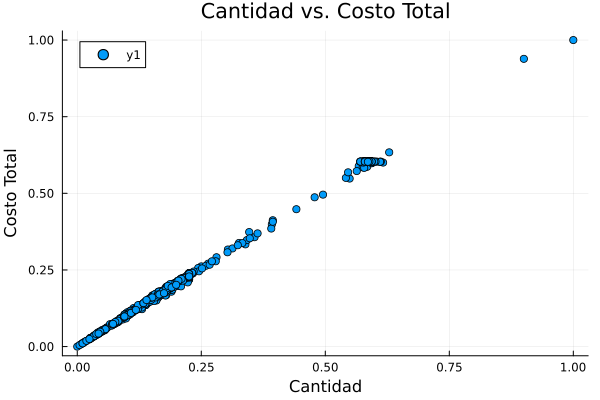

In [14]:
scatter(shuffled_df.Cantidad_Norm, shuffled_df.Costo_Total_Norm, title="Cantidad vs. Costo Total", xlabel="Cantidad", ylabel="Costo Total")

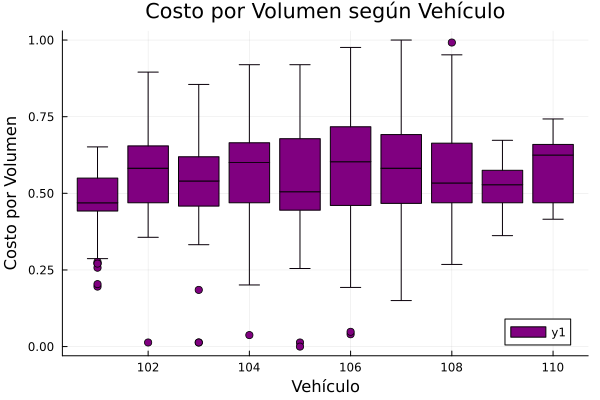

In [15]:
boxplot(shuffled_df.Vehiculo, shuffled_df.Costo_Por_Volumen_Norm, title="Costo por Volumen según Vehículo", xlabel="Vehículo", ylabel="Costo por Volumen", color="purple")

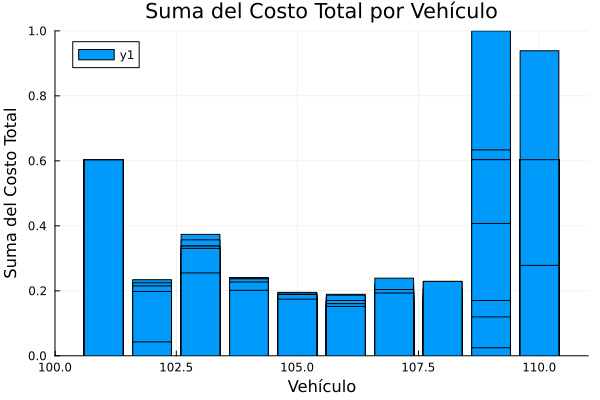

In [16]:
bar(shuffled_df.Vehiculo, shuffled_df.Costo_Total_Norm, title="Suma del Costo Total por Vehículo", xlabel="Vehículo", ylabel="Suma del Costo Total")

# Función de clasificación
Predeciremos la unidad con el

Odometro

Tanque_Lleno

Costo_Total

## Hipótesis

In [24]:
# creamod un hyp_df con las columnas a usar
# Odometro_Norm Float
# Tanque_Lleno_Norm Bool
# Costo_Total_Norm Float
hyp_df = select(shuffled_df, [:Odometro_Norm, :Tanque_Lleno, :Costo_Total_Norm])
y = shuffled_df[:, :Vehiculo]
# Normalizamos y
y = normalize_vector(y)

function hyp(bias::Float64, theta::Vector{Float64}, hyp_df::DataFrame)
    sum = 0.0
    # y = theta1*x1 + theta2*x2 + theta3*x3
    for column in length(theta)
        for j in column
            sum = sum + theta[column] * hyp_df[!, column][j]
        end
    end
    sum += bias
    # Funcion sigmoide
    sum = 1/(1 + exp(-sum))
    return sum
end

hyp (generic function with 1 method)

## Imprimir todo

In [25]:
# Funcion para imprimir
function printInfo(epochs::Int64, theta::Vector{Float64}, general_error::Float64)
    println("Epoch: ", epochs)
    println("Theta: ", theta)
    println("Error: ", general_error)
    println("\n------------------------\n")
end

printInfo (generic function with 1 method)

## Funcion de obtencion de error

In [29]:
function show_errors(theta::Vector{Float64}, bias::Float64,hyp_df::DataFrame, y::Vector{Float64})
    error_acum = 0.0
    error = 0.0

    for (column_index, column) in enumerate(eachcol(hyp_df))
        hyp_value_for_error = hyp(bias, theta, hyp_df)
        for i in 1:length(column)
            if y[i] == 1
                if hyp_value_for_error == 0
                    hyp_value_for_error = 0.0001
                end
                error = -log(hyp_value_for_error)
            elseif y[i] == 0
                if hyp_value_for_error == 1
                    hyp_value_for_error = 0.9999
                end
                error = -log(1 - hyp_value_for_error)
            end
            error_acum += error
        end
    return error_acum
    end
end

show_errors (generic function with 1 method)

## Funcion Gradiente Descendiente

In [30]:
function GD(theta::Vector{Float64}, bias::Float64, hyp_df::DataFrame, y::Vector{Float64}, alpha::Float64, epochs::Int64)
    theta_location = 1

    for (column_index, column) in enumerate(eachcol(hyp_df))
        acum = 0.0
        hyp_value = hyp(bias, theta, hyp_df)
        for i in 1:length(column)
            error = hyp_value - y[i]
            acum += error * column[i]
        end
        theta[theta_location] -= alpha * (1 / length(y)) * acum
        theta_location += 1
    end
    println(theta)
    return theta
end

GD (generic function with 1 method)

## Separating Data - Train - Test

In [31]:
# 90% for training
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

@assert train_ratio + validation_ratio + test_ratio == 1.0

# Calcular el número de muestras para el conjunto de entrenamiento
n_train = floor(Int, train_ratio * nrow(hyp_df))
n_val = floor(Int, validation_ratio * nrow(hyp_df))

# Separar los índices en entrenamiento y prueba
train_hyp_df = hyp_df[1:n_train, :]
validation_hyp_df = hyp_df[(n_train+1):(n_train+n_val), :]
test_hyp_df = hyp_df[(n_train+n_val+1):end, :]

train_y = y[1:n_train]
validation_y = y[(n_train+1):(n_train+n_val)]
test_y = y[(n_train+n_val+1):end]

64-element Vector{Float64}:
 1.0
 0.7777777777777778
 0.7777777777777778
 0.6666666666666666
 0.3333333333333333
 1.0
 0.6666666666666666
 0.0
 0.4444444444444444
 0.7777777777777778
 ⋮
 0.0
 0.1111111111111111
 0.5555555555555556
 0.8888888888888888
 0.4444444444444444
 0.6666666666666666
 0.3333333333333333
 0.7777777777777778
 0.1111111111111111

# El momento de la verdad

In [32]:
epochs = 600
alpha = 0.03
theta = [float(rand(-1:1)), float(rand(-1:1)), float(rand(-1:1))]
bias = 0.0

while epochs > 0
    theta = GD(theta, bias, train_hyp_df, train_y, alpha, epochs)
    epochs -= 1
    printInfo(epochs, theta, show_errors(theta, bias, train_hyp_df, train_y))
end

[1.000354789260014, 1.0030145070660634, -0.9990377213323351]
Epoch: 599
Theta: [1.000354789260014, 1.0030145070660634, -0.9990377213323351]
Error: 362.72269197111655

------------------------

[1.0007079249841204, 1.0060265275930855, -0.9980761526142541]
Epoch: 598
Theta: [1.0007079249841204, 1.0060265275930855, -0.9980761526142541]
Error: 362.6973249857217

------------------------

[1.0010594082353788, 1.0090360631796644, -0.9971152933893296]
Epoch: 597
Theta: [1.0010594082353788, 1.0090360631796644, -0.9971152933893296]
Error: 362.6719989191623

------------------------

[1.0014092400765426, 1.012043115423938, -0.9961551432012659]
Epoch: 596
Theta: [1.0014092400765426, 1.012043115423938, -0.9961551432012659]
Error: 362.6467137123628

------------------------

[1.0017574215700586, 1.0150476859235822, -0.995195701593899]
Epoch: 595
Theta: [1.0017574215700586, 1.0150476859235822, -0.995195701593899]
Error: 362.6214693063291

------------------------

[1.0021039537780656, 1.018049776275